In [7]:
# TTLS  A : (M X N1 X N2 X Q)   y:(M X 1)  x: (N1 x N2 X Q)
import tensorly as tl
import torch
import numpy as np
from utils import c_conj, c_distance, create_error, make_CDP_operator
from tls_utils import tls_update_a
from tr_nm import prox_tr_nuclear_norm, tr_nuclear_norm,tr_rand
from tensorly.decomposition._tr import tensor_ring
import PIL.Image as Image

def norm_estimate(y):
    # Estimate norm of signal from measurements
    return np.sqrt(0.5*np.sum(y)/y.shape[0])

def spectralInit(y,A, tr_rank, image_dims,iterations):
    """ Function for spectral initialization with higher-order SVD.
        Arguments:
            tucker_rank: List of mulitilinear ranks
            image_dims: Tuple of dimensions of the image
            Y: Observation matrix with dimensions (m x q)
            A: Measurement tensor with dimensions (n x m x q)

    """   

    S = np.array(c_conj(A) @ (y*A), dtype=A.dtype)
    
    x0 = np.array(np.random.normal(size=[N, 1]) + 
                  1j*np.random.normal(size=[N, 1]), dtype=A.dtype)
    x0 = x0 / np.linalg.norm(x0)
    
    # Power iterations to calculate leading eigenvector of S
    for i in range(iterations):
        v = S @ x0
        x0 = v / np.linalg.norm(v)
        
    X=x0.reshape(image_dims)
    # low rank    
    factor_mats = tensor_ring(X,tr_rank)
    X=tl.tr_to_tensor(factor_mats)
    
    return X

def x_update_grad(y, A, x):
    # Gradient update for signal
    
    M = A.shape[0]
    grad = c_conj(A) @ ((np.abs(A @ x)**2 - y)*(A @ x) / M) 
    
    return grad

def x_update_grad_tensor(y, A, x, m,o,lam_y,theta):
    # Gradient update for signal
    
    M = A.shape[0]
    grad =2*lam_y* c_conj(A) @ ((np.abs(A @ x)**2 - y)*(A @ x) / M) -theta*(m-x+o/theta)
    
    return grad

def ttls(y, A, X0, initial_lr, n_iter, norm_estimate, lam_a, lam_y,lam_m,orig_x,print_itear=False):    
    X = X0.copy()
    temp_dis=1000
    select_x=X0.copy()
    O=np.array(np.zeros(X.shape)+1j*np.zeros(X.shape),dtype=X.dtype)
    theta=0.9#/np.prod(X.shape)
    loss_prev = np.inf
    Am=A.reshape(y.shape[0],-1)
    M=X
    lr = initial_lr#*(norm_estimate**4)/lam_a
    xv=X.reshape(-1,1)

    for i in range(n_iter):
        # Update sensing vectors
        Am_updated = tls_update_a(y, Am, xv, norm_estimate, lam_a, lam_y)
        # Update signal
        mv=M.reshape(-1,1)
        ov=O.reshape(-1,1)
        #fun_a=(1/ (2*y.shape[0]))*lam_y*np.linalg.norm((y - np.abs(Am_updated@xv)**2))**2+(theta/2)*np.linalg.norm(M - X+O/theta)**2
        xv -= (lr/(norm_estimate**2))*x_update_grad_tensor(y, Am_updated, xv, mv,ov,lam_y,theta)
        X=xv.reshape(X.shape)
        # fun_b=(1/ (2*y.shape[0]))*lam_y*np.linalg.norm((y - np.abs(Am_updated@xv)**2))**2+(theta/2)*np.linalg.norm(M - X+O/theta)**2
        # update M
        M=prox_tr_nuclear_norm(X-O/theta,lam_m/theta)
        #update O
        O += theta*(M-X)
        # Evaluate loss
        data_loss = np.linalg.norm((y - np.abs(Am_updated@xv)**2))**2
        a_loss = np.linalg.norm(Am - Am_updated)**2
        m_loss =lam_m*tr_nuclear_norm(M)+(theta/2)*np.linalg.norm(M - X+O/theta)**2
        loss = (1/ (2*y.shape[0])) * (lam_y*data_loss + (lam_a)*a_loss)+m_loss
        
        # Stop if loss change is small
        loss_diff = np.abs(loss - loss_prev)
        if (loss_diff < 1e-6):
            break
        loss_prev = loss

        xv_ttls=X.reshape(-1,1)
        dis= c_distance( orig_x, xv_ttls)/np.linalg.norm(orig_x)
        if print_itear:
            print('i:{},loss:{},loss_dif:{}'.format(i,loss_prev,loss_diff))
            print ('TTLS distance: ', dis)

        if dis<temp_dis:
            select_x=X.copy()
            temp_dis=dis
            if print_itear:
                print('select_dis:, ', temp_dis)
    print ('TTLS iterations done: ', i+1)
    
    return select_x, Am_updated

############################################################################### 

if __name__ == "__main__":
    np.random.seed(0)
    frame_num=3
    DTYPE=np.complex128
    # DTYPE=np.float64
    N_1 = 30
    N_2 = 10
    Q = frame_num
    N=N_1*N_2*Q
    L=4
    M=L*N
    # Number of measurements

    data=np.array(np.random.randint(0,256,size=[N_1, N_2,frame_num]), dtype=DTYPE)    
    data=np.array(np.random.normal(size=[N_1, N_2,frame_num]), dtype=DTYPE)*256
    data=np.zeros((10,30,frame_num),dtype=DTYPE)

    for i in range(frame_num):
        image_file='./data/'+str(i+1)+'.jpg'
        image = Image.open(image_file)
        image_data = np.array(image,dtype=DTYPE)
        data[:,:,i]=image_data
    
    
    
    a_SNR=30
    y_SNR=30

    # sampling_mode = 'Real'
    # sampling_mode = 'Complex'
    sampling_mode = 'CDP'
    
    np.random.seed(0)
    print ('N: ' + str(N) + ', M: ' + str(M) + ', a_SNR: ' + str(a_SNR) + ', y_SNR: ' + str(y_SNR))
    x=data.reshape(-1,1)
    
    # Create Real, Gaussian or CDP sensing vectors
    if sampling_mode == 'CDP':
        print ('Using coded diffraction measurement model')
        Am = make_CDP_operator(N, int(M / N), x.dtype, 'octanary')
        
    if sampling_mode == 'Real':
        print ('Using Real Gaussian measurement model') 
        Am = np.array(np.random.normal(size=[M, N]), dtype=np.float64)
        
    if sampling_mode == 'Complex':
        print ('Using Complex Gaussian measurement model') 
        Am = np.array(np.random.normal(size=[M, N]) + 1j*np.random.normal(size=[M, N]), dtype=np.complex128)

    # Create sensing vector errors
    E = np.array(np.random.normal(size=Am.shape) + 
                1j*np.random.normal(size=Am.shape), dtype=Am.dtype)
    
    # Obtain clean measurements
    xv=data.reshape(-1,1)
    y = np.abs(Am @ xv)**2

    # Create measurem
    # Create measurement errors
    e = np.random.normal(size=y.shape)
    
    # Scale sensing vector and measurement errors according to SNR
    Delta = create_error(Am, E, a_SNR)
    eta = create_error(y, e, y_SNR)
    
    # Perturb sensing vectors and measurements
    Am_measured = Am + Delta
    y_measured = y + eta

    A_measured = Am_measured.reshape([M,N_1,N_2,Q])
    print('Am_measured.shape',Am_measured.shape)
    print('y_measured.shape',y_measured.shape)
    # Original clean sensing vectors and measurements are no longer required
    del Am, y, E, e, Delta, eta
        
    norm__estimate = norm_estimate(y_measured)
    X0=spectralInit(y_measured, Am_measured, 2, [N_1,N_2,Q],50)
    X0 = X0 * norm__estimate
    print ('Initialization distance: ' + str(c_distance(xv, X0)/np.linalg.norm(xv)) + '\n')


    alpha = 1e11
    beta = 1
    lam_a = alpha*beta/N
    lam_y = alpha/ (norm__estimate**4)
    lam_m = 5e1
    ttls_lr = 2e6
    ttls_iter = 1000
    
    print ('N: ' + str(N) + ', M: ' + str(M) + ', a_SNR: ' + str(a_SNR) + ', y_SNR: ' + str(y_SNR)+' L:' + str(L))
    print ('alpha: ' + str(alpha) + ', beta: ' + str(beta) + ', lam_m: ' + str(lam_m) + ', step_size: ' + str(ttls_lr) )
    X_ttls, A_updated = ttls(y_measured, A_measured, X0, ttls_lr, ttls_iter, norm__estimate, lam_a, lam_y,lam_m,xv,print_itear=False)
    xv_ttls=X_ttls.reshape(-1,1)
    ttls_dis=c_distance(xv, xv_ttls)/np.linalg.norm(xv)
    print ('TTLS distance:{}  \n'.format(ttls_dis))


N: 900, M: 3600, a_SNR: 30, y_SNR: 30
Using coded diffraction measurement model
Am_measured.shape (3600, 900)
y_measured.shape (3600, 1)
Initialization distance: 0.7872979938569828

N: 900, M: 3600, a_SNR: 30, y_SNR: 30 L:4
alpha: 100000000000.0, beta: 1, lam_m: 50.0, step_size: 2000000.0
TTLS iterations done:  1000
TTLS distance:0.0538417669100899  



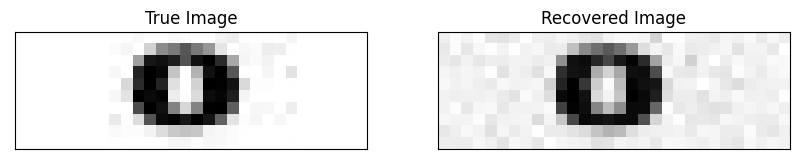

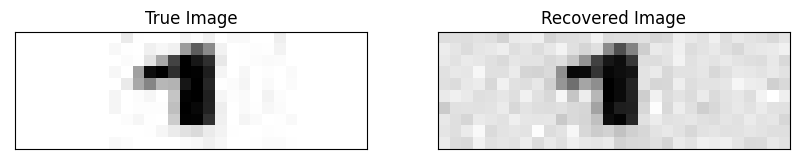

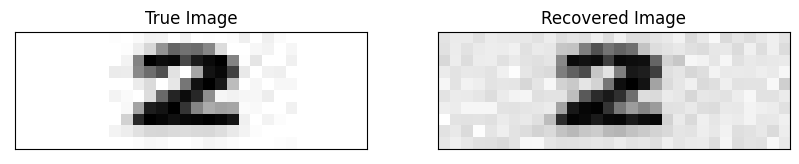

In [9]:
import matplotlib.pyplot as plt
plt.style.use('default')
# 假设 'data' 和 'X_ttls' 是你的3D数组，'frame_num' 是帧数
for i in range(frame_num):
    # 创建一个图和两个子图，1行2列
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # 在第一个子图上绘制True Image
    axs[0].imshow(np.abs(data[:,:,i]), cmap='gray')
    axs[0].set_title('True Image')
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    # 在第二个子图上绘制Recovered Image
    axs[1].imshow(np.abs(X_ttls[:,:,i].reshape([10,30])), cmap='gray')
    axs[1].set_title('Recovered Image')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    # 显示图像
    plt.show()
